# 小分子溶解度LogS性质的预测 

In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

## 1 数据探索及预处理

In [2]:
ds = pd.read_csv('LogS.csv', index_col='mid')
ds.head(5)

,smiles,prop
mid,,
0,c3ccc2nc1ccccc1cc2c3,-3.670
1,Cc1cc(cc(N(=O)=O)c1O)N(=O)=O,-1.456
2,CN(C)C(=O)NC1CC2CC1C3CCCC23,-3.171
3,CC(C)c1ccc(C)cc1O,-2.220
4,Cc1ccc(cc1)S(=O)(=O)N,-1.740


In [3]:
ds.describe()

,prop
count,1028.000000
mean,-3.038169
std,2.100335
min,-11.600000
25%,-4.292500
50%,-2.820000
75%,-1.600000
max,1.580000


检查一下prop(LogS)性质的范围

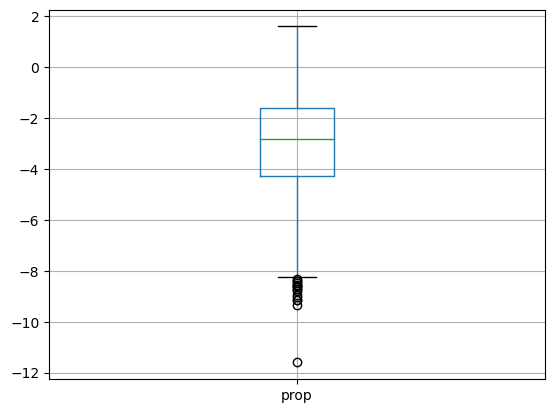

In [4]:
ds.boxplot('prop')
plt.show()

随机挑几个小分子作图

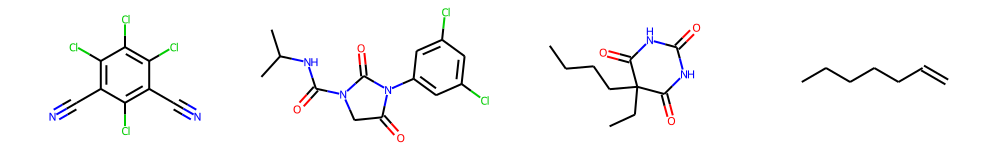

mid
186            c1(C#N)c(Cl)c(C#N)c(Cl)c(Cl)c(Cl)1
35     CC(C)NC(=O)N1CC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2
466                    CCCCC1(CC)C(=O)NC(=O)NC1=O
815                                      CCCCCC=C
Name: smiles, dtype: object

In [5]:
from rdkit.Chem import Draw
from rdkit import Chem
from IPython.display import SVG, display

def draw_smiles(smiles_list):
    mols = [Chem.MolFromSmiles(x) for x in smiles_list]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,150), legends=[], useSVG=True)
    display(img)

random_smiles = ds.smiles.sample(4)
draw_smiles(random_smiles)
random_smiles

将SMILES格式统一成规范化的SMILES

In [6]:
from rdkit.Chem import CanonSmiles
ds['canonical_smiles'] = ds.smiles.apply(CanonSmiles)
ds.head(3)

,smiles,prop,canonical_smiles
mid,,,
0,c3ccc2nc1ccccc1cc2c3,-3.670,c1ccc2nc3ccccc3cc2c1
1,Cc1cc(cc(N(=O)=O)c1O)N(=O)=O,-1.456,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O
2,CN(C)C(=O)NC1CC2CC1C3CCCC23,-3.171,CN(C)C(=O)NC1CC2CC1C1CCCC21


检查一下是否规范化后有重复的smiles

In [7]:
len(ds.smiles.unique()), len(ds.canonical_smiles.unique())

(1028, 1018)

删除规范化后有重复的小分子

In [8]:
ds.drop_duplicates('canonical_smiles', keep='first', inplace=True)
ds.drop('smiles', axis=1, inplace=True)
ds.rename({'canonical_smiles':'smiles'}, axis=1, inplace=True)
ds

,prop,smiles
mid,,
0,-3.670,c1ccc2nc3ccccc3cc2c1
1,-1.456,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O
2,-3.171,CN(C)C(=O)NC1CC2CC1C1CCCC21
3,-2.220,Cc1ccc(C(C)C)c(O)c1
4,-1.740,Cc1ccc(S(N)(=O)=O)cc1
...,...,...
1022,-0.020,NC(=O)CCl
1023,0.450,Cc1cccc(C)n1
1025,-0.910,COc1cnc2cncnc2n1


## 2 小分子聚类分析（PCA and t-SNE）

计算分子指纹向量

In [9]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

In [10]:
ds['fp'] = ds.smiles.apply(lambda x: np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToList()))
ds.fp[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0])

PCA分析

> PCA（principal components analysis）即主成分分析技术，又称主分量分析，旨在利用降维的思想，把多指标转化为少数几个综合指标。
在统计学中，主成分分析PCA是一种简化数据集的技术。它是一个线性变换。这个变换把数据变换到一个新的坐标系统中，使得任何数据投影的第一大方差在第一个坐标(称为第一主成分)上，第二大方差在第二个坐标(第二主成分)上，依次类推。主成分分析经常用于减少数据集的维数，同时保持数据集的对方差贡献最大的特征。这是通过保留低阶主成分，忽略高阶主成分做到的。这样低阶成分往往能够保留住数据的最重要方面。

In [11]:
from sklearn.decomposition import PCA

X = np.array(ds.fp.to_list())
pca_m = PCA(n_components=2, random_state=42)
pca_r = pca_m.fit_transform(X)
pca_r

array([[-0.24675651, -1.6288625 ],
       [ 1.98414095, -0.5382132 ],
       [ 1.28700361,  0.50863255],
       ...,
       [ 2.01850571, -0.8777217 ],
       [ 0.50905472,  0.15280194],
       [ 0.17080897,  1.22292675]])

In [12]:
ds['PC1'] = pca_r.T[0]
ds['PC2'] = pca_r.T[1]
ds['prop_cat'] = ds.prop.apply(lambda x: 'high' if x>-1.5 else ('low' if x<-4.5 else 'med'))
ds.prop_cat.value_counts()

med     552
high    241
low     225
Name: prop_cat, dtype: int64

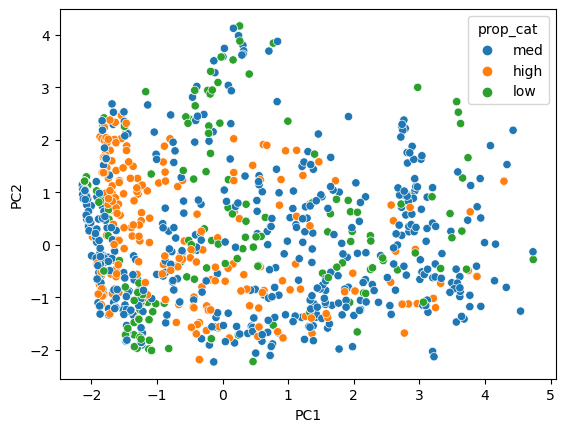

In [13]:
sb.scatterplot(x='PC1', y='PC2', hue='prop_cat', data=ds)
plt.show()

t-SNE分析与作图

> t分布随机邻域嵌入 (t-SNE) 是一种统计方法，用于通过为每个数据点在二维或三维地图中的位置来可视化高维数据。它基于最初由 Sam Roweis 和 Geoffrey Hinton 开发的随机邻域嵌入。它是一种非线性降维技术，非常适合在二维或三维的低维空间中嵌入用于可视化的高维数据。

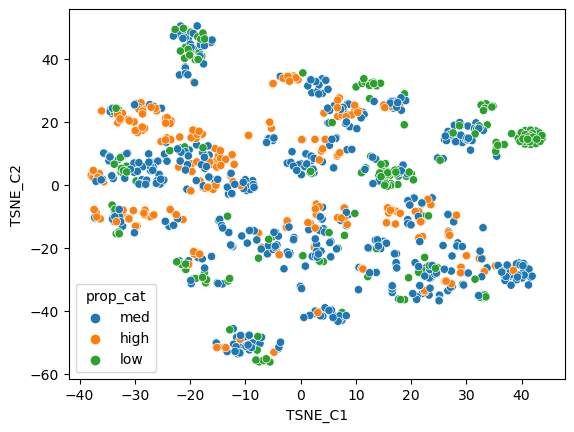

In [14]:
from sklearn.manifold import TSNE
tsne_m = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=5000)
tsne_r = tsne_m.fit_transform(X)
ds['TSNE_C1'] = tsne_r.T[0]
ds['TSNE_C2'] = tsne_r.T[1]

sb.scatterplot(x='TSNE_C1', y='TSNE_C2', hue='prop_cat', data=ds)
plt.show()

清理一下数据集

In [15]:
ds = ds[['smiles', 'prop']].copy()
ds.head()

,smiles,prop
mid,,
0,c1ccc2nc3ccccc3cc2c1,-3.670
1,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,-1.456
2,CN(C)C(=O)NC1CC2CC1C1CCCC21,-3.171
3,Cc1ccc(C(C)C)c(O)c1,-2.220
4,Cc1ccc(S(N)(=O)=O)cc1,-1.740


## 3 小分子的特征表示（分子基本物化性质、分子描述符、分子指纹）

In [16]:
from rdkit.Chem import Lipinski, Descriptors

def get_descriptors_from_mol(mol):
    descriptors = {
        'molwt': Descriptors.MolWt(mol),
        'logp': Descriptors.MolLogP(mol),
        'rtb': Descriptors.NumRotatableBonds(mol),
        'hba': Descriptors.NumHAcceptors(mol), 
        'hbd': Descriptors.NumHDonors(mol),
        'molmr': Descriptors.MolMR(mol),
        'heavyatomcount': Descriptors.HeavyAtomCount(mol),
        'tpsa': Descriptors.TPSA(mol)
    }
    return descriptors

我们来看一下简单分子的物化性质，比如乙醇

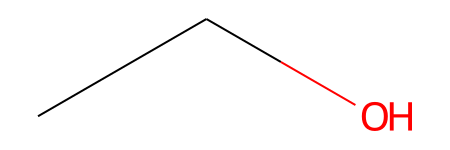

In [19]:
ethanol = Chem.MolFromSmiles('CCO')
ethanol

In [20]:
get_descriptors_from_mol(ethanol)

{'molwt': 46.069,
 'logp': -0.0014000000000000123,
 'rtb': 0,
 'hba': 1,
 'hbd': 1,
 'molmr': 12.759800000000002,
 'heavyatomcount': 3,
 'tpsa': 20.23}

In [21]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def to_array(fp, size=2048):
    arr = np.zeros((0,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr[:size]

In [22]:
# add features to dataset
ds['descriptors'] = ds.smiles.apply(lambda x: get_descriptors_from_mol(Chem.MolFromSmiles(x)))
ds['rdkit_fp'] = ds.smiles.apply(lambda x: to_array(Chem.rdmolops.RDKFingerprint(Chem.MolFromSmiles(x)), 256))
ds['maccs_fp'] = ds.smiles.apply(lambda x: to_array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x))))
ds['morgan_fp'] = ds.smiles.apply(lambda x: to_array(GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, 256)))
ds.head(2)

,smiles,prop,descriptors,rdkit_fp,maccs_fp,morgan_fp
mid,,,,,,
0,c1ccc2nc3ccccc3cc2c1,-3.670,"{'molwt': 179.22199999999998, 'logp': 3.388000...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,-1.456,"{'molwt': 198.134, 'logp': 1.5170199999999998,...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [23]:
row = ds.iloc[0]
list(map(len, [row.rdkit_fp, row.maccs_fp, row.morgan_fp]))

[256, 167, 256]

构造特征列X，和标签列Y

In [24]:
# 把之前计算的小分子理化性质特征，各种分子指纹特征等打平，连接在一起
def parse_feature_vector(row):
    return np.concatenate([np.array(list(row.descriptors.values())), row.rdkit_fp, row.maccs_fp, row.morgan_fp])
    # return np.concatenate([np.array(list(row.descriptors.values()))])

ds['X'] = ds.apply(parse_feature_vector, axis=1)
ds.X[0]

array([179.222,   3.388,   0.   ,   1.   ,   0.   ,  59.249,  14.   ,
        12.89 ,   1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   1.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,   1.   ,
         0.   ,   0.   ,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,
         1.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.

In [25]:
ds.X[0].shape

(687,)

In [26]:
ds['Y'] = ds.prop

In [27]:
ds.head(1).T

mid,0
smiles,c1ccc2nc3ccccc3cc2c1
prop,-3.67
descriptors,"{'molwt': 179.22199999999998, 'logp': 3.388000..."
rdkit_fp,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
maccs_fp,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
morgan_fp,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
X,"[179.22199999999998, 3.3880000000000017, 0.0, ..."
Y,-3.67


Hint: 
```
下面所述的CatBoost包提供了处理embedding类型数据的更好方法
参考https://catboost.ai/en/docs//concepts/python-reference_pool
可以自行尝试一下是否有更优的结果。
>

## 4 数据集划分

In [ ]:
ds = ds.sample(frac=1.0, random_state=42)
train_ds = ds.iloc[:900,:].copy()
test_ds = ds.iloc[900:,:].copy()
print(len(train_ds), len(test_ds))

检查两个数据集性质分布一致性

In [ ]:
plt.boxplot(x=[train_ds.prop, test_ds.prop])
plt.show()

In [ ]:
test_ds.head(1).T

## 5 训练CatBoost模型

CatBoost is a high-performance open source library for gradient boosting on decision trees

In [ ]:
import catboost as cb
model = cb.CatBoostRegressor(loss_function='MAE', verbose=False)

In [ ]:
x_train = np.stack(train_ds.X.values)
y_train_true = train_ds.Y.values
cb_train_ds = cb.Pool(x_train, y_train_true)

In [ ]:
model.fit(cb_train_ds, verbose=True)

## 6 模型指标计算

In [ ]:
from typing import OrderedDict
import scipy
from sklearn.metrics import (explained_variance_score, mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score, roc_auc_score)

def calculate_metrics(y_true, y_pred):
    def smape(A, F):
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return OrderedDict({
        'r2': explained_variance_score(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred),
        'smape': smape(y_true, y_pred),
        'pcc': scipy.stats.pearsonr(y_true, y_pred)
    })

In [ ]:
y_train_pred = model.predict(x_train)
calculate_metrics(y_train_true, y_train_pred)

In [ ]:
x_test = np.stack(test_ds.X.values)
y_test_true = test_ds.Y.values
cb_test_ds = cb.Pool(x_test, y_test_true)

In [ ]:
y_test_pred = model.predict(x_test)
calculate_metrics(y_test_true, y_test_pred)

In [ ]:
sb.scatterplot(x=y_test_pred, y=y_test_true)

In [ ]:
sb.regplot(x=y_test_pred, y=y_test_true)

## 7 模型的可解释性

In [ ]:
feature_names = np.array(['molwt', 'logp', 'rtb', 'hba', 'hbd', 'molmr', 'heavyatomcount', 'tpsa'] + [f'rdkit_fp_{i}' for i in range(256)] + \
    [f'maccs_fp_{i}' for i in range(167)] + [f'morgan_fp_{i}' for i in range(256)])

In [ ]:
len(feature_names)

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()[-10:]
plt.barh(feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.show()

LogP, MolMR, HBA等几个基础性质贡献最大